In [11]:
import sys
sys.path.insert(0, "../../src/")
from framework import *
from algorithms import nelder_mead_multi
import optuna

In [12]:
nelder_mead_multi.load_best_instance('../../result/june.db')
save_handler = SaveHandlerJSON('../../result/june/')

# No hyper-param is needed for Nelder Mead
nm_ins = AlgorithmInstance(algorithm=nelder_mead_multi, trial=optuna.trial.FixedTrial({}), instance_index=-1)
# nelder_mead_multi.load_best_instance(result_db_path)
nm_ins.load_results(save_handler=save_handler, partial=False)

In [13]:
nm_ins.performance_measures()

{'success_rate': 0.25,
 'failure_rate': 0.75,
 'success_cnt': 6,
 'avg_success_eval': np.float64(22821.166666666668),
 'hv': np.float64(6794.708333333333),
 'par2': 80705.29166666667,
 'par10': 380705.2916666667,
 'avg_height': np.float64(1320.3137966615043),
 'ert': np.float64(172821.16666666666),
 'sp': np.float64(91284.66666666667),
 'success_rate_upper': np.float64(0.44899825312106434),
 'success_rate_lower': np.float64(0.11999203479342332),
 'success_rate_length': np.float64(0.32900621832764104),
 'gary_ert': np.float64(8295.416)}

In [15]:
res = nm_ins.results[2]
len(res.end_of_iterations)

706

In [17]:
print(res.end_of_iterations[:20])

[134, 208, 272, 338, 411, 496, 577, 648, 712, 776, 829, 913, 993, 1057, 1125, 1190, 1266, 1343, 1409, 1477]


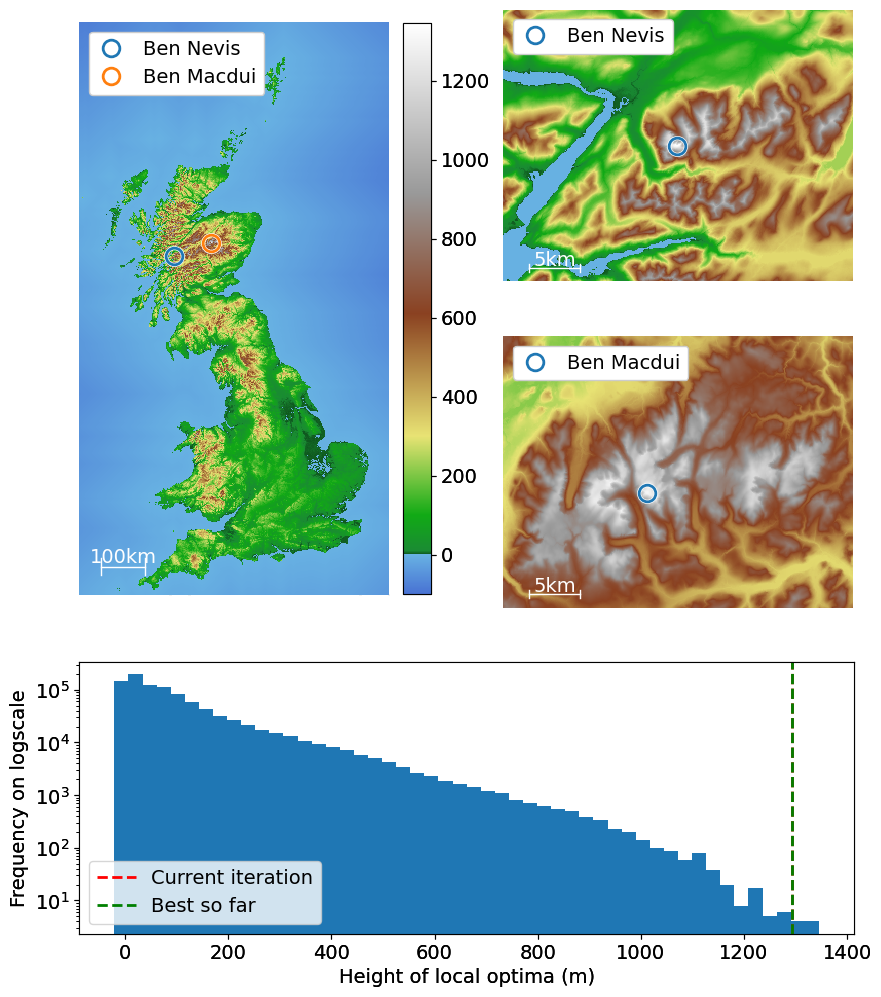

In [19]:
import numpy as np
maxima_heights = np.load('../../basin-problem/res/maxima_heights.npy')

from framework import ResultAnimation

# we only render the first 20 frames for demonstration;
# for the full video, change frame_num to None
result_animation = ResultAnimation(res, maxima_heights, frame_num=1477, mode='evaluations')
result_animation.save(file_name='animation/Nelder-Mead-2.mp4', fps=5)

(<Figure size 341x265 with 1 Axes>,
 <Axes: >,
 array([[-5.0010681e-02, -3.0006409e-02, -2.0004272e-02, ...,
          4.2270001e+02,  4.3370001e+02,  4.4470001e+02],
        [-7.0014954e-02, -5.0010681e-02, -4.0008545e-02, ...,
          4.0950000e+02,  4.1800000e+02,  4.2910001e+02],
        [-9.0019226e-02, -7.0014954e-02, -6.0012817e-02, ...,
          3.9470001e+02,  3.9779999e+02,  4.0950000e+02],
        ...,
        [ 1.8280000e+02,  1.6780000e+02,  1.8450000e+02, ...,
          3.6560001e+02,  3.7070001e+02,  3.6870001e+02],
        [ 2.0750000e+02,  1.9839999e+02,  1.8339999e+02, ...,
          3.8200000e+02,  3.9400000e+02,  3.9410001e+02],
        [ 2.4100000e+02,  2.2680000e+02,  2.1500000e+02, ...,
          3.8210001e+02,  4.1939999e+02,  4.2179999e+02]], dtype=float32),
 <function nevis._plot.plot.<locals>.meters2indices(x, y)>)

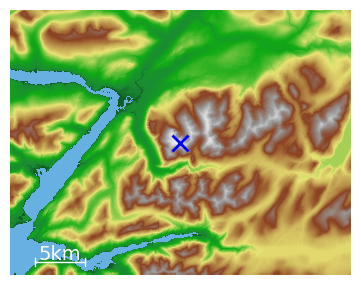

In [20]:
import nevis
ben_x, ben_y = nevis.ben().grid
ben_x, ben_y
f = nevis.linear_interpolant()
f(ben_x, ben_y)
ben_x, ben_y
b = 8e3
nevis.plot(
            
            boundaries=[ben_x - b * 2.125,
                        ben_x + b * 2.125,
                        ben_y - b * 1.65,
                        ben_y + b * 1.65],
            zoom=1/1.5,
            points=np.array([[ben_x, ben_y]])
            
        )

In [21]:
nm_ins.performance_measures()

{'success_rate': 0.25,
 'failure_rate': 0.75,
 'success_cnt': 6,
 'avg_success_eval': np.float64(22821.166666666668),
 'hv': np.float64(6794.708333333333),
 'par2': 80705.29166666667,
 'par10': 380705.2916666667,
 'avg_height': np.float64(1320.3137966615043),
 'ert': np.float64(172821.16666666666),
 'sp': np.float64(91284.66666666667),
 'success_rate_upper': np.float64(0.44899825312106434),
 'success_rate_lower': np.float64(0.11999203479342332),
 'success_rate_length': np.float64(0.32900621832764104),
 'gary_ert': np.float64(8295.416)}

In [22]:
nm_ins.performance_to_latex()

'Nelder-Mead\t& 24\t& 25\\%\t& 1320\t& \\(1.73 \\times 10^{5}\\) \t& \\(8.30 \\times 10^{3}\\) \\\\'

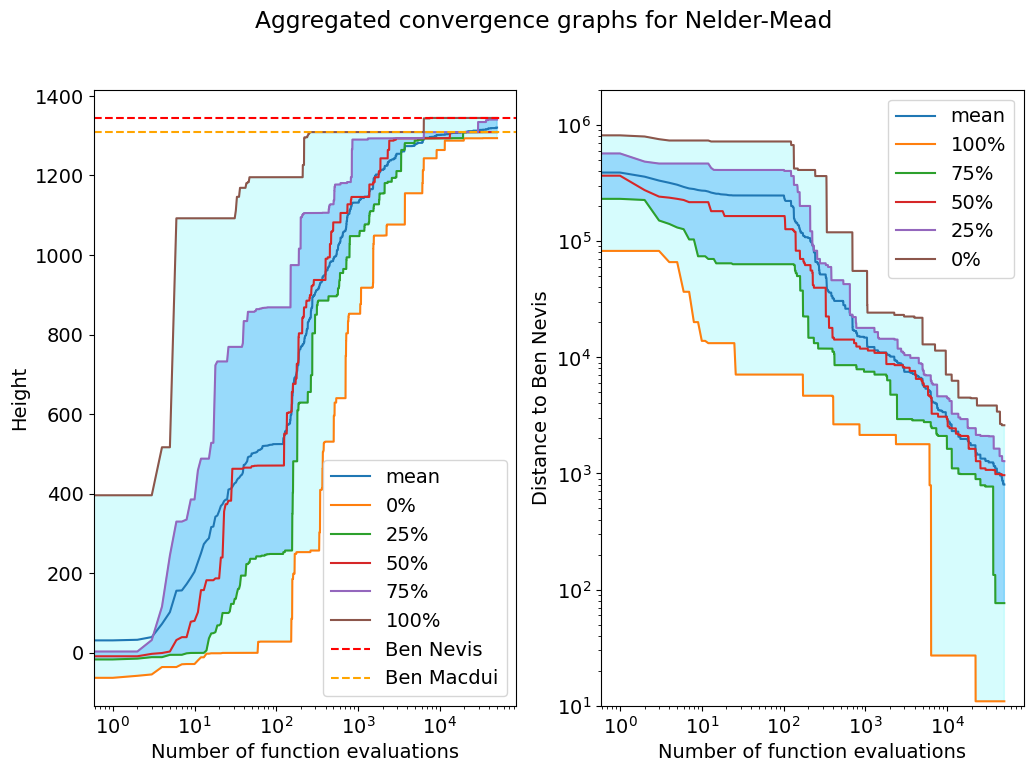

In [23]:
nm_ins.plot_convergence_graph()

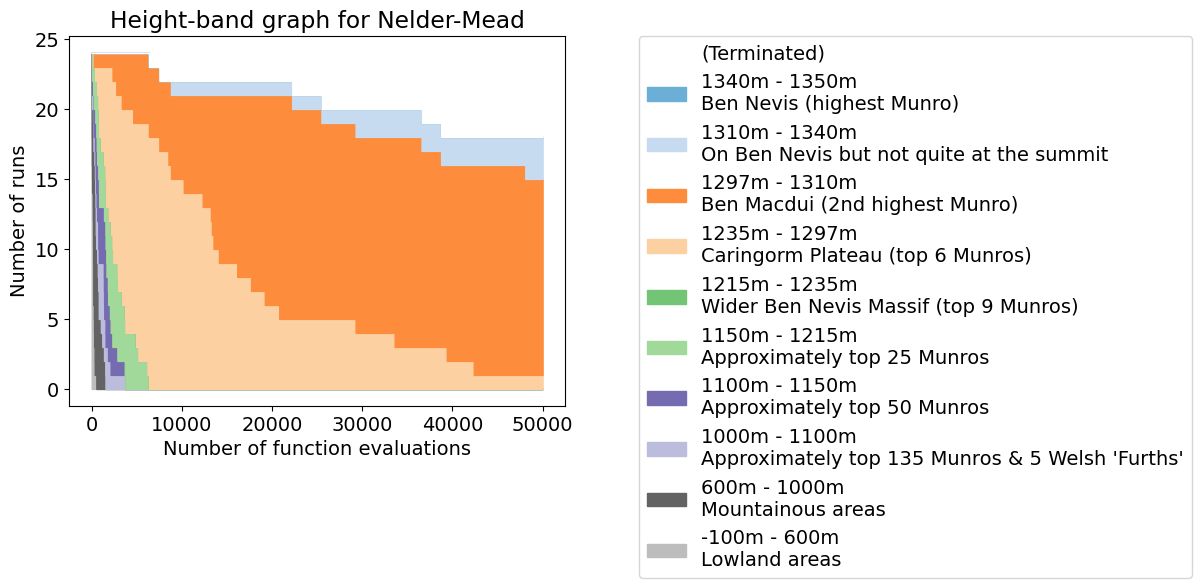

In [24]:
nm_ins.plot_stacked_graph(mode='terminate')

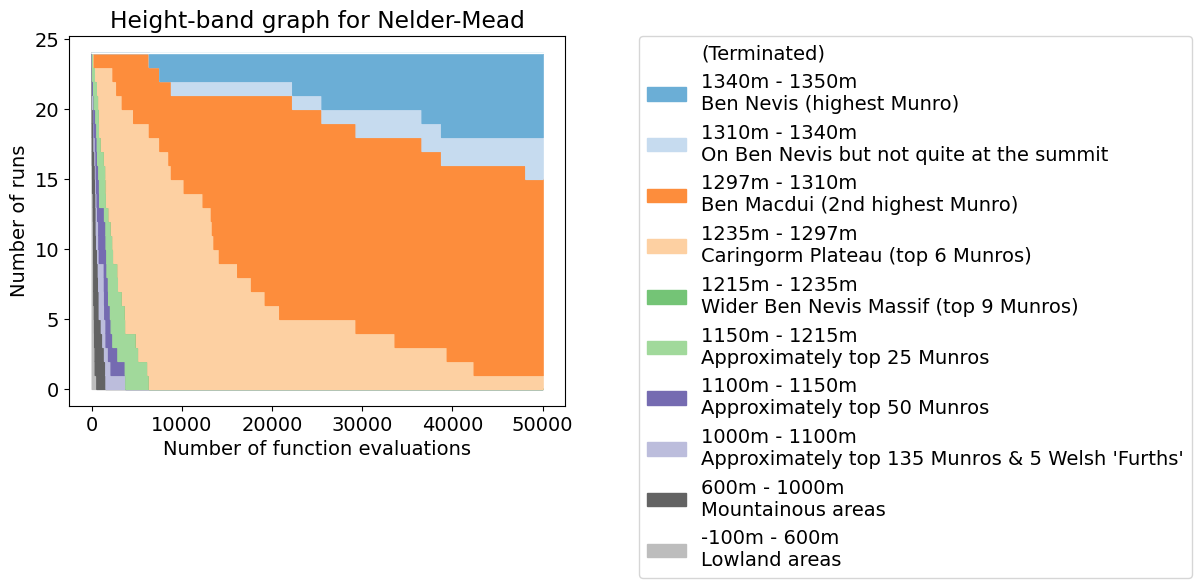

In [26]:
nm_ins.plot_stacked_graph()


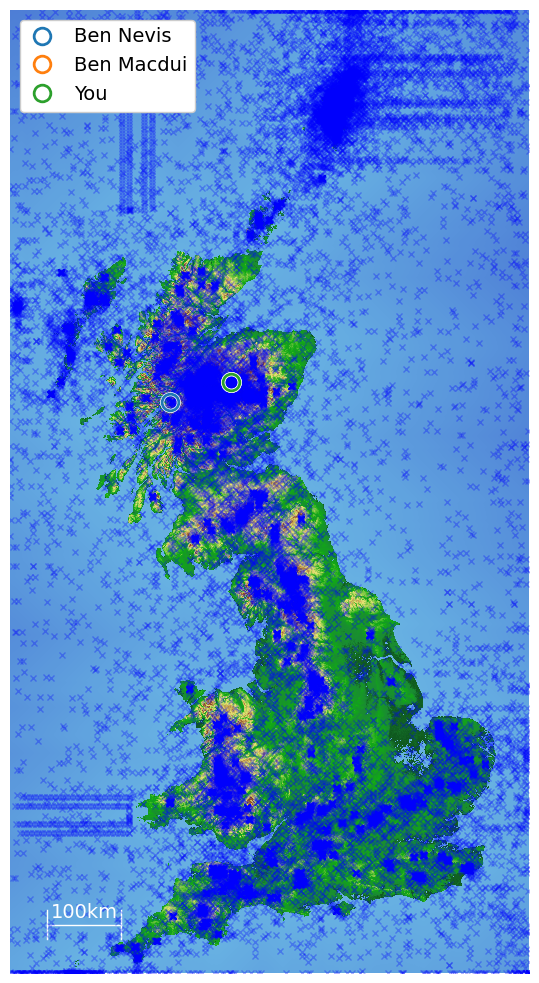

In [25]:
res = nm_ins.results[4]
res.plot_global()